<a href="https://colab.research.google.com/github/carlos-edhr/hands-on-ml/blob/main/02_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning Classification

 This notebook is about machine learning classification using the MNIST dataset, which is a set of 70,000 images of handwritten digits. Each image is labeled with the digit it represents.

In [12]:
# Environment setup
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## MNIST

In [13]:
# Scikit-Learn provided function to downlaod MNIST
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [14]:
# Data-Target arrays are included in datasets loaded by Scikit-learn
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [15]:
y.shape

(70000,)

Saving figure some_digit_plot


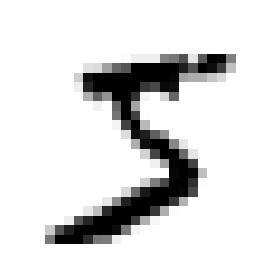

In [16]:
# Show digit from dataset
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")

save_fig("some_digit_plot")
plt.show()

In [17]:
# Previous digit label
y[0]

'5'

In [18]:
y = y.astype(np.uint8)

In [19]:
# Creating a test set
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Training a Binary Classifier

We will start the solution by identifying just one digit.

In [21]:
y_train_5 = (y_train == 5) # True for all numbers: 5
y_test_5 = (y_test == 5)

Next we proceed to choose a classifier and train it.

In [22]:
# Estimator: SGDClassifier - Stochastic Gradient Descent
from sklearn.linear_model import SGDClassifier 

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

Our model can now detect images of the number 5

In [25]:
# the some_digit variable was previously set to 5
sgd_clf.predict([some_digit])

array([ True])

It seems that at this stage our model performs correctly, now we proceed to evaluate it's performance.

## Performance Measures

### Measuring accuracy using cross-validation

**Implementing cross-validation**

For greater control over cross-validation we can create our own function:

In [27]:
# Custom implementation of Scikit-Learn's cross_val_score()
from sklearn.model_selection import StratifiedKFold 
from sklearn.base import clone 

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
  clone_clf = clone(sgd_clf)
  X_train_folds = X_train[train_index]
  y_train_folds = y_train_5[train_index]
  X_test_fold = X_train[test_index]
  y_test_fold = y_train_5[test_index]

  clone_clf.fit(X_train_folds, y_train_folds)
  y_pred = clone_clf.predict(X_test_fold)
  n_correct = sum(y_pred == y_test_fold)
  print(n_correct / len(y_pred)) 

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


0.95035
0.96035
0.9604


Now we evaluate the SGDClassifier model with cross_val_score().

In [29]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=5, scoring="accuracy")

array([0.95466667, 0.96975   , 0.9635    , 0.96533333, 0.94841667])

The ratio of correct predictions is high - 96% - however let's take a look at a classifier of "not-5" images: 

In [32]:
# Detect if element is not 5
from sklearn.base import BaseEstimator 

class Never5Classifier(BaseEstimator):
  def fit(self, X, y=None):
    return self
  def predict(self, X):
    return np.zeros((len(X), 1), dtype=bool)


In [33]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

Accuracy is high because only 10% of the images are 5s.

This shows that accuracy is generally not the preferred performance measure for classifiers.